Starting data scraping for 20 pages...
Processing page 1 of 1


C:\Users\capta\AppData\Local\Temp\ipykernel_7216\2505511951.py:482: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  amazon_df['title'].replace('', np.nan, inplace=True)
C:\Users\capta\AppData\Local\Temp\ipykernel_7216\2505511951.py:528: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_brands.index, y=top5_brands.values, palette="Blues_r")


Scraped data for 32 products across 20 pages.
Processing and analyzing data...
Data processing complete.
Generating visualizations...


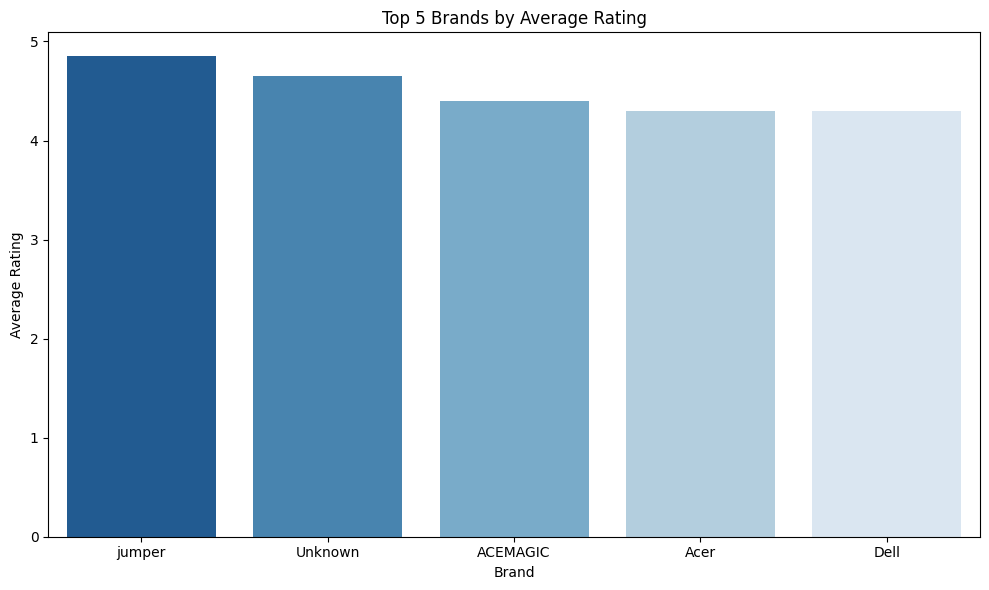

C:\Users\capta\AppData\Local\Temp\ipykernel_7216\2505511951.py:544: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=price_bins, y=df['rating_clean'], palette="coolwarm")


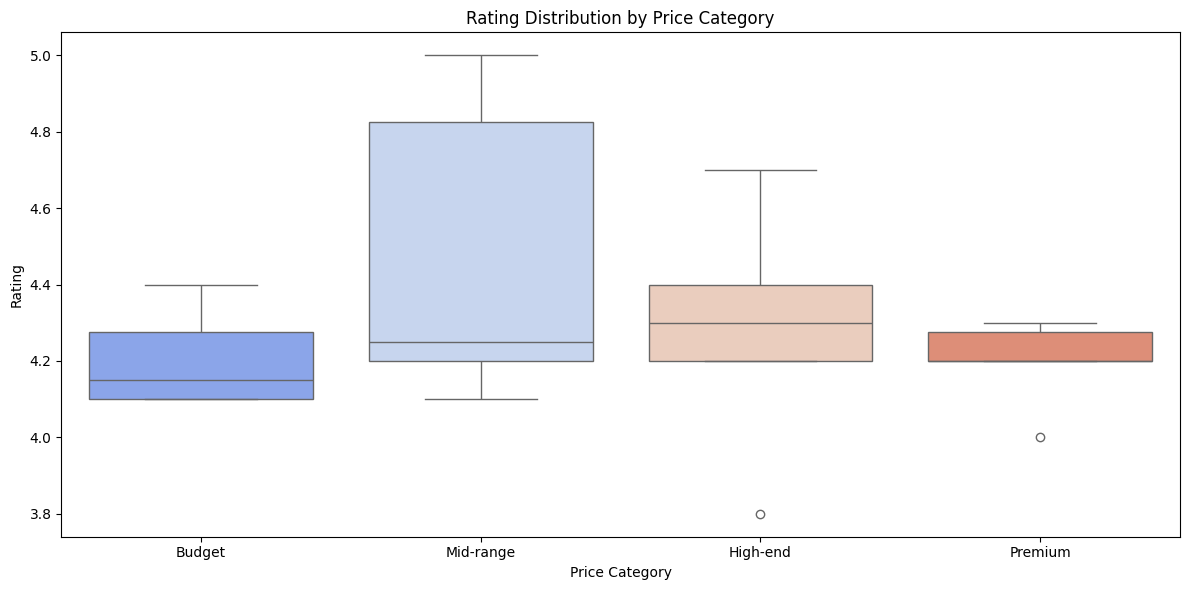

C:\Users\capta\AppData\Local\Temp\ipykernel_7216\2505511951.py:558: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  review_counts = df.groupby(price_bins)['review_count_clean'].sum()
C:\Users\capta\AppData\Local\Temp\ipykernel_7216\2505511951.py:561: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=review_counts.index, y=review_counts.values, palette="viridis")


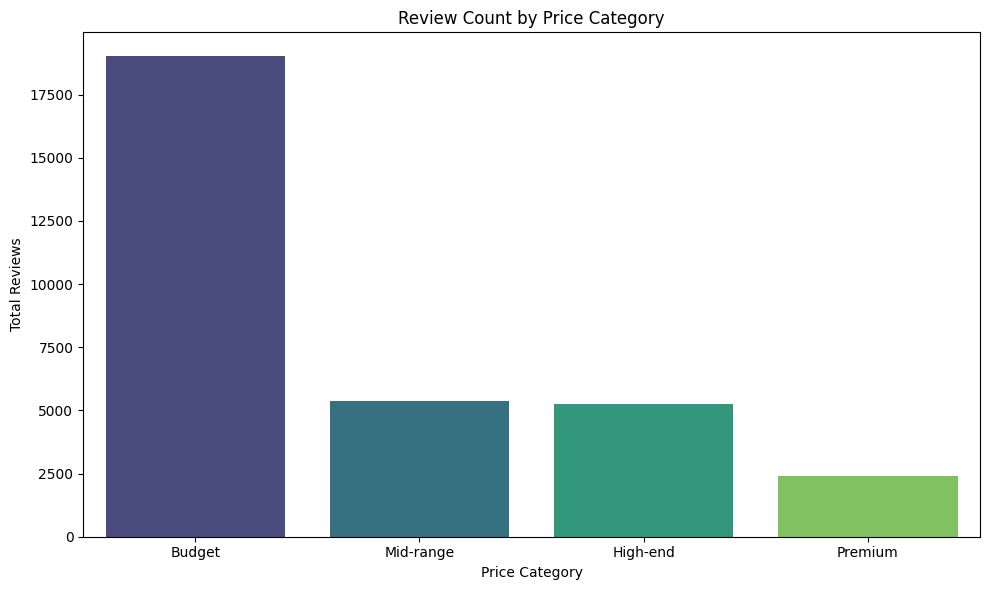

C:\Users\capta\AppData\Local\Temp\ipykernel_7216\593255174.py:554: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['rating_clean'], y=df['ram'], palette="coolwarm")


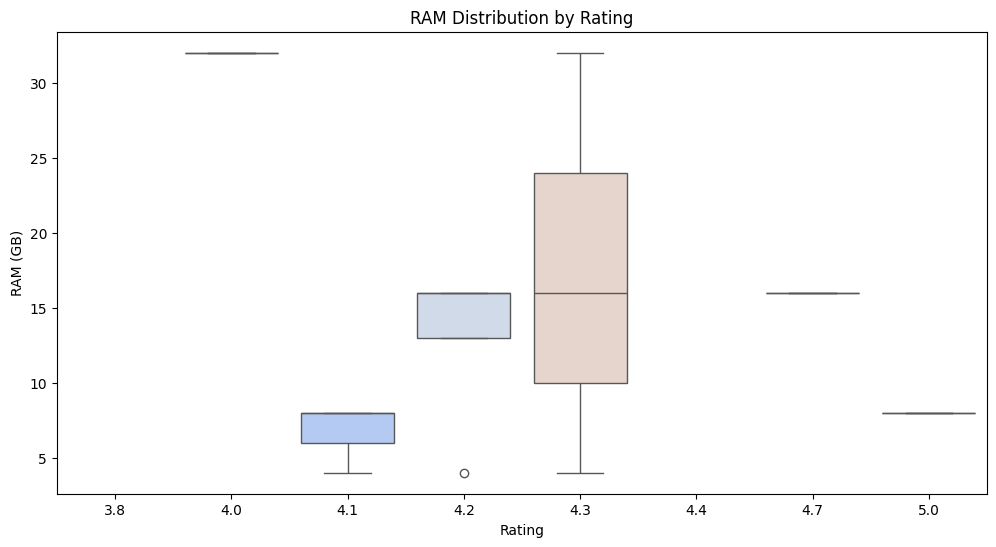

Error during visualization: 'rom'
Generating analysis report...
Report generated successfully.


<Figure size 1200x600 with 0 Axes>

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import re
from datetime import datetime

# Function to extract Product Title
def get_title(soup):
    try:
        # Outer Tag Object
        title = soup.find("span", attrs={"id":'productTitle'})
        
        # Inner NavigatableString Object
        title_value = title.text

        # Title as a string value
        title_string = title_value.strip()

    except AttributeError:
        title_string = ""

    return title_string

# Function to extract Product Price
def get_price(soup):
    try:
        # Method 1: Find price structure with separate components
        price_symbol = soup.find("span", attrs={"class":'a-price-symbol'})
        price_whole = soup.find("span", attrs={"class":'a-price-whole'})
        price_fraction = soup.find("span", attrs={"class":'a-price-fraction'})
        
        if price_symbol and price_whole and price_fraction:
            symbol = price_symbol.text.strip()
            whole = price_whole.text.strip().replace(',', '')  # Remove commas
            fraction = price_fraction.text.strip()
            price = f"{symbol}{whole}.{fraction}"
            return price
            
        # Method 2: Find by a-price class and check child components
        price_element = soup.find("span", attrs={"class":'a-price'})
        if price_element:
            symbol = price_element.find("span", attrs={"class":'a-price-symbol'})
            whole = price_element.find("span", attrs={"class":'a-price-whole'})
            fraction = price_element.find("span", attrs={"class":'a-price-fraction'})
            
            if symbol and whole and fraction:
                price = f"{symbol.text.strip()}{whole.text.strip().replace(',', '')}.{fraction.text.strip()}"
                return price
        
        # Method 3: Find by a-offscreen class
        offscreen_price = soup.find("span", attrs={"class":'a-offscreen'})
        if offscreen_price:
            return offscreen_price.text.strip()
            
        # Method 4: Find special deals
        deal_price = soup.find("span", attrs={'id':'priceblock_dealprice'})
        if deal_price:
            return deal_price.text.strip()
            
        # Method 5: Find regular price
        our_price = soup.find("span", attrs={'id':'priceblock_ourprice'})
        if our_price:
            return our_price.text.strip()
            
    except Exception as e:
        print(f"Price extraction error: {str(e)}")
        
    return "not available"

# Function to extract discount information
def get_discount(soup):
    try:
        # Try to find the discount percentage
        discount_element = soup.find("span", attrs={"class":"a-size-large a-color-price savingPriceOverride"})
        if discount_element:
            return discount_element.text.strip()
            
        # Alternative method - find savings percentage
        savings_element = soup.find("span", attrs={"class":"a-size-base a-color-secondary"})
        if savings_element and "%" in savings_element.text:
            return savings_element.text.strip()
            
        # Look for strike-through price to calculate discount
        strike_price = soup.find("span", attrs={"class":"a-text-strike"})
        current_price_element = soup.find("span", attrs={"class":"a-offscreen"})
        
        if strike_price and current_price_element:
            try:
                strike_price_value = clean_price(strike_price.text.strip())
                current_price_value = clean_price(current_price_element.text.strip())
                
                if strike_price_value > 0 and current_price_value > 0:
                    discount_percentage = ((strike_price_value - current_price_value) / strike_price_value) * 100
                    return f"{discount_percentage:.1f}%"
            except:
                pass
                
    except Exception as e:
        print(f"Discount extraction error: {str(e)}")
        
    return "No discount"
 
# Function to extract Product Rating
def get_rating(soup):
    try:
        rating = soup.find("i", attrs={'class':'a-icon a-icon-star a-star-4-5'}).string.strip()
    
    except AttributeError:
        try:
            rating = soup.find("span", attrs={'class':'a-icon-alt'}).string.strip()
        except:
            rating = ""    

    return rating

# Function to extract Number of User Reviews
def get_review_count(soup):
    try:
        review_count = soup.find("span", attrs={'id':'acrCustomerReviewText'}).string.strip()

    except AttributeError:
        review_count = ""    

    return review_count

# Function to extract Availability Status
def get_availability(soup):
    try:
        available = soup.find("div", attrs={'id':'availability'})
        available = available.find("span").string.strip()

    except AttributeError:
        available = "Not Available"    

    return available

# Function to extract product specifications/details
def get_specs(soup):
    specs = {}
    try:
        # Try to get specs from product details section
        details_section = soup.find("div", attrs={"id": "productDetails_techSpec_section_1"})
        if details_section:
            rows = details_section.find_all("tr")
            for row in rows:
                key = row.find("th").text.strip()
                value = row.find("td").text.strip()
                specs[key] = value
        
        # Try alternate section for specs
        if not specs:
            details_section = soup.find("div", attrs={"id": "detailBullets_feature_div"})
            if details_section:
                list_items = details_section.find_all("li")
                for item in list_items:
                    text = item.text.strip()
                    if ":" in text:
                        key_value = text.split(":", 1)
                        specs[key_value[0].strip()] = key_value[1].strip()
    except Exception as e:
        print(f"Spec extraction error: {str(e)}")
    
    return specs

# Function to extract display size
def get_display_size(soup, title):
    try:
        # First try to get from specifications
        specs = get_specs(soup)
        
        # Check if display size is in specs
        for key in specs:
            if "display" in key.lower() or "screen" in key.lower() or "monitor" in key.lower():
                if "inch" in specs[key].lower() or '"' in specs[key]:
                    return specs[key]
        
        # If not found in specs, try to extract from title
        display_pattern = r'(\d+\.?\d?)[\s-]?inch|(\d+\.?\d?)[\s-]?"'
        match = re.search(display_pattern, title, re.IGNORECASE)
        if match:
            size = match.group(1) if match.group(1) else match.group(2)
            return f"{size} inch"
    except Exception as e:
        print(f"Display size extraction error: {str(e)}")
    
    return "Not specified"

# Function to extract laptop brand
def get_brand(title):
    try:
        # Common laptop brands
        brands = [
            "HP", "Lenovo", "Acer", "ASUS", "Dell", "Apple", "jumper", "Microsoft", 
            "MSI", "Samsung", "IST Computers", "AOC", "ACEMAGIC", "LG", "ApoloSign", 
            "Alienware", "CHUWI", "GIGABYTE", "Machenike", "Gateway", "Razer", 
            "Oemgenuine", "Hewlett Packard", "EXCaliberPC", "mCover", "Bmax", 
            "Intel", "Panasonic", "Toshiba", "Toughbook", "Spigen"
        ]
        
        # Check if any brand appears in the title
        for brand in brands:
            pattern = r'\b' + re.escape(brand) + r'\b'
            if re.search(pattern, title, re.IGNORECASE):
                return brand
    except Exception as e:
        print(f"Brand extraction error: {str(e)}")
    
    return "Unknown"

# Function to clean price data
def clean_price(price_str):
    try:
        if not isinstance(price_str, str):
            return np.nan
        # Remove currency symbol and any extra dots
        price_str = re.sub(r'[^\d.]', '', price_str)
        # Fix double dots issue
        if '..' in price_str:
            price_str = price_str.replace('..', '.')
        
        # Convert to float
        return float(price_str)
    except:
        return np.nan

# Function to clean rating data
def clean_rating(rating_str):
    try:
        # Extract the numeric part of the rating and convert to float
        if isinstance(rating_str, str):
            match = re.search(r'([\d.]+)', rating_str)
            if match:
                return float(match.group(1))
        return np.nan
    except:
        return np.nan

# Function to clean review count data
def clean_review_count(review_str):
    try:
        # Remove commas and non-numeric characters
        review_count = re.sub(r'[^\d]', '', review_str)
        return float(review_count)
    except:
        return np.nan

# Function to categorize laptops by price range
def categorize_by_price(price):
    if pd.isna(price):
        return "Unknown"
    elif price < 200:
        return "Budget"
    elif price < 500:
        return "Mid-range"
    elif price < 800:
        return "High-end"
    else:
        return "Premium"

# Function to analyze laptop specifications and extract key features
def analyze_laptop_features(titles):
    ram_pattern = r'(\d+)\s*GB RAM'
    storage_pattern = r'(\d+)\s*(?:GB|TB) (?:SSD|HDD|Storage)'
    processor_patterns = [
        r'Intel (?:Core )?i(\d)',
        r'AMD Ryzen (\d)',
        r'Intel Celeron',
        r'Intel Pentium'
    ]
    
    features = {
        'ram': [],
        'storage': [],
        'processor_type': []
    }
    
    for title in titles:
        if not isinstance(title, str):
            features['ram'].append(np.nan)
            features['storage'].append(np.nan)
            features['processor_type'].append(np.nan)
            continue
            
        # Extract RAM
        ram_match = re.search(ram_pattern, title, re.IGNORECASE)
        if ram_match:
            features['ram'].append(int(ram_match.group(1)))
        else:
            features['ram'].append(np.nan)
        
        # Extract Storage
        storage_match = re.search(storage_pattern, title, re.IGNORECASE)
        if storage_match:
            features['storage'].append(int(storage_match.group(1)))
        else:
            features['storage'].append(np.nan)
        
        # Extract Processor Type
        processor_found = False
        for pattern in processor_patterns:
            if re.search(pattern, title, re.IGNORECASE):
                processor_found = True
                if 'Intel Core' in title or 'i3' in title or 'i5' in title or 'i7' in title or 'i9' in title:
                    features['processor_type'].append('Intel Core')
                elif 'AMD Ryzen' in title:
                    features['processor_type'].append('AMD Ryzen')
                elif 'Intel Celeron' in title:
                    features['processor_type'].append('Intel Celeron')
                elif 'Intel Pentium' in title:
                    features['processor_type'].append('Intel Pentium')
                break
        
        if not processor_found:
            features['processor_type'].append(np.nan)
    
    return pd.DataFrame(features)

# Function to extract RAM explicitly from product page
def get_ram(soup, title):
    try:
        # First try to get from specifications
        specs = get_specs(soup)
        
        # Check if RAM is in specs
        for key in specs:
            if "ram" in key.lower() or "memory" in key.lower():
                ram_spec = specs[key]
                ram_match = re.search(r'(\d+)\s*GB', ram_spec, re.IGNORECASE)
                if ram_match:
                    return int(ram_match.group(1))
        
        # If not found in specs, try to extract from title
        ram_pattern = r'(\d+)\s*GB RAM'
        match = re.search(ram_pattern, title, re.IGNORECASE)
        if match:
            return int(match.group(1))
    except Exception as e:
        print(f"RAM extraction error: {str(e)}")
    
    return np.nan

# Function to extract ROM/Storage explicitly from product page
def get_storage(soup, title):
    try:
        # First try to get from specifications
        specs = get_specs(soup)
        
        # Check if storage is in specs
        for key in specs:
            if "storage" in key.lower() or "ssd" in key.lower() or "hdd" in key.lower() or "drive" in key.lower():
                storage_spec = specs[key]
                storage_match = re.search(r'(\d+)\s*(GB|TB)', storage_spec, re.IGNORECASE)
                if storage_match:
                    size = int(storage_match.group(1))
                    unit = storage_match.group(2).upper()
                    return f"{size} {unit}"
        
        # If not found in specs, try to extract from title
        storage_pattern = r'(\d+)\s*(GB|TB)\s*(SSD|HDD|Storage|ROM)'
        match = re.search(storage_pattern, title, re.IGNORECASE)
        if match:
            size = match.group(1)
            unit = match.group(2).upper()
            return f"{size} {unit}"
    except Exception as e:
        print(f"Storage extraction error: {str(e)}")
    
    return "Not specified"

# Function to add random delay between requests
def random_delay():
    delay = random.uniform(1, 5)
    time.sleep(delay)

# Main scraping function with support for 20 pages
def scrape_amazon_products(urls):
    all_data = {
        "title": [], 
        "brand": [],
        "price": [], 
        "rating": [], 
        "reviews": [],
        "availability": [],
        "ram": [],
        "storage": [],
        "display_size": [],
        "discount": [],
        "url": []
    }
    
    # List of user agents to rotate
    user_agents = [
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.84 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 12_3_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.3 Safari/605.1.15',
        'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.79 Safari/537.36'
    ]
    
    # Process each URL
    for page_num, URL in enumerate(urls, 1):
        print(f"Processing page {page_num} of {len(urls)}")
        
        # Choose a random user agent
        headers = {
            'User-Agent': random.choice(user_agents),
            'Accept-Language': 'en-US, en;q=0.5'
        }
        
        try:
            # HTTP Request with error handling
            response = requests.get(URL, headers=headers)
            
            # Check if request was successful
            if response.status_code != 200:
                print(f"Failed to retrieve page {page_num}. Status code: {response.status_code}")
                continue
            
            # Parse the page
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Fetch links
            links = soup.find_all("a", attrs={'class':'a-link-normal s-no-outline'})
            links_list = [link.get('href') for link in links]
            
            # Process each product link
            for link in links_list:
                try:
                    # Add random delay to avoid rate limiting
                    random_delay()
                    
                    product_url = "https://www.amazon.com" + link
                    
                    # Use a different user agent for each product request
                    product_headers = {
                        'User-Agent': random.choice(user_agents),
                        'Accept-Language': 'en-US, en;q=0.5'
                    }
                    
                    product_response = requests.get(product_url, headers=product_headers)
                    
                    if product_response.status_code != 200:
                        print(f"Failed to retrieve product. Status code: {product_response.status_code}")
                        continue
                    
                    product_soup = BeautifulSoup(product_response.content, "html.parser")
                    
                    # Extract product title
                    title = get_title(product_soup)
                    
                    # Extract product information
                    all_data['title'].append(title)
                    all_data['brand'].append(get_brand(title))
                    all_data['price'].append(get_price(product_soup))
                    all_data['rating'].append(get_rating(product_soup))
                    all_data['reviews'].append(get_review_count(product_soup))
                    all_data['availability'].append(get_availability(product_soup))
                    all_data['ram'].append(get_ram(product_soup, title))
                    all_data['storage'].append(get_storage(product_soup, title))
                    all_data['display_size'].append(get_display_size(product_soup, title))
                    all_data['discount'].append(get_discount(product_soup))
                    all_data['url'].append(product_url)
                    
                except Exception as e:
                    print(f"Error processing product: {str(e)}")
            
            # Add delay between pages
            if page_num < len(urls):
                time.sleep(random.uniform(5, 10))
                
        except Exception as e:
            print(f"Error on page {page_num}: {str(e)}")
    
    # Create DataFrame
    amazon_df = pd.DataFrame.from_dict(all_data)
    
    # Clean data
    amazon_df['title'].replace('', np.nan, inplace=True)
    amazon_df = amazon_df.dropna(subset=['title'])

    
    return amazon_df
    
# Function to clean and analyze the data
def process_and_analyze_data(df):
    # Create a copy of the DataFrame to avoid modifying the original
    processed_df = df.copy()

    # Clean price data
    processed_df['price_clean'] = processed_df['price'].apply(clean_price)
    
    # Clean rating data
    processed_df['rating_clean'] = processed_df['rating'].apply(clean_rating)
    
    # Clean review count
    processed_df['review_count_clean'] = processed_df['reviews'].apply(clean_review_count)
    
    # Categorize by price
    processed_df['price_category'] = processed_df['price_clean'].apply(categorize_by_price)
    
    # Check for duplicates
    processed_df = processed_df.drop_duplicates(subset=['title'])
    
    return processed_df
# Error during data processing: cannot access local variable 'processed_df' where it is not associated with a value


# Function to visualize brand distribution
# def visualize_brand_distribution(df):
#     plt.figure(figsize=(12, 8))
#     brand_counts = df['brand'].value_counts().head(10)  # Top 10 brands
#     sns.barplot(x=brand_counts.index, y=brand_counts.values)
#     plt.title('Top 10 Laptop Brands')
#     plt.xlabel('Brand')
#     plt.ylabel('Count')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.savefig('brand_distribution.png')
def visualize_top5_brands(df):
    if 'brand' in df.columns and 'rating_clean' in df.columns:
        top5_brands = df.groupby('brand')['rating_clean'].mean().nlargest(5)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top5_brands.index, y=top5_brands.values, palette="Blues_r")
        plt.xlabel("Brand")
        plt.ylabel("Average Rating")
        plt.title("Top 5 Brands by Average Rating")
        plt.tight_layout()
        plt.savefig('top5_brands.png')
        plt.show()
    else:
        print("Required columns 'brand' or 'rating_clean' not found in DataFrame.")

def visualize_rating_by_price(df):
    if 'price_clean' in df.columns and 'rating_clean' in df.columns:
        df = df.dropna(subset=['price_clean', 'rating_clean'])
        price_bins = pd.qcut(df['price_clean'], q=4, labels=["Budget", "Mid-range", "High-end", "Premium"])
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=price_bins, y=df['rating_clean'], palette="coolwarm")
        plt.xlabel("Price Category")
        plt.ylabel("Rating")
        plt.title("Rating Distribution by Price Category")
        plt.tight_layout()
        plt.savefig('rating_by_price.png')
        plt.show()
    else:
        print("Required columns 'price_clean' or 'rating_clean' not found in DataFrame.")

def visualize_review_count_by_price(df):
    if 'price_clean' in df.columns and 'review_count_clean' in df.columns:
        df = df.dropna(subset=['price_clean', 'review_count_clean'])
        price_bins = pd.qcut(df['price_clean'], q=4, labels=["Budget", "Mid-range", "High-end", "Premium"])
        review_counts = df.groupby(price_bins)['review_count_clean'].sum()
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=review_counts.index, y=review_counts.values, palette="viridis")
        plt.xlabel("Price Category")
        plt.ylabel("Total Reviews")
        plt.title("Review Count by Price Category")
        plt.tight_layout()
        plt.savefig('review_count_by_price.png')
        plt.show()
    else:
        print("Required columns 'price_clean' or 'review_count_clean' not found in DataFrame.")

# Function to visualize RAM distribution
# def visualize_ram_distribution(df):
#     plt.figure(figsize=(10, 6))
#     # Filter out NaN values
#     ram_df = df[df['ram'].notna()]
#     ram_counts = ram_df['ram'].value_counts().sort_index()
    
#     if not ram_counts.empty:
#         sns.barplot(x=ram_counts.index.astype(str), y=ram_counts.values)
#         plt.title('Distribution of Laptops by RAM Size')
#         plt.xlabel('RAM (GB)')
#         plt.ylabel('Count')
#         plt.tight_layout()
#         plt.savefig('ram_distribution.png')

# # Function to visualize price distribution
# def visualize_price_distribution(df):
#     plt.figure(figsize=(10, 6))
#     sns.histplot(df['price_clean'].dropna(), bins=10, kde=True)
#     plt.title('Distribution of Laptop Prices')
#     plt.xlabel('Price ($)')
#     plt.ylabel('Frequency')
#     plt.tight_layout()
#     plt.savefig('price_distribution.png')
    
#     # Box plot
#     plt.figure(figsize=(12, 6))
#     sns.boxplot(x=df['price_clean'].dropna())
#     plt.title('Boxplot of Laptop Prices')
#     plt.xlabel('Price ($)')
#     plt.tight_layout()
#     plt.savefig('price_boxplot.png')

# # Function to visualize rating vs price
# def visualize_rating_vs_price(df):
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(data=df, x='price_clean', y='rating_clean', size='review_count_clean', 
#                     sizes=(20, 200), alpha=0.7)
#     plt.title('Rating vs Price (size represents number of reviews)')
#     plt.xlabel('Price ($)')
#     plt.ylabel('Rating (out of 5)')
#     plt.tight_layout()
#     plt.savefig('rating_vs_price.png')

# # Function to visualize price categories
# def visualize_price_categories(df):
#     plt.figure(figsize=(10, 6))
#     category_counts = df['price_category'].value_counts()
#     sns.barplot(x=category_counts.index, y=category_counts.values)
#     plt.title('Distribution of Laptops by Price Category')
#     plt.xlabel('Price Category')
#     plt.ylabel('Count')
#     plt.tight_layout()
#     plt.savefig('price_categories.png')

# # Function to visualize display size distribution
# def visualize_display_size(df):
#     # Extract numeric display sizes
#     display_sizes = []
#     for size in df['display_size']:
#         if isinstance(size, str):
#             match = re.search(r'(\d+\.?\d?)', size)
#             if match:
#                 display_sizes.append(float(match.group(1)))
    
#     if display_sizes:
#         plt.figure(figsize=(10, 6))
#         sns.histplot(display_sizes, bins=8, kde=True)
#         plt.title('Distribution of Display Sizes')
#         plt.xlabel('Display Size (inches)')
#         plt.ylabel('Frequency')
#         plt.tight_layout()
#         plt.savefig('display_size_distribution.png')

# # Function to visualize storage types and sizes
# def visualize_storage(df):
#     if 'storage' not in df.columns:
#         print("Column 'storage' not found in DataFrame.")
#         return
    
#     # Kiểm tra NaN trước khi tính toán
#     df['storage'] = df['storage'].fillna('')

#     # Tính số lượng SSD và HDD
#     ssd_count = df['storage'].str.contains('SSD', na=False, case=False).sum()
#     hdd_count = df['storage'].str.contains('HDD', na=False, case=False).sum()
    
#     # Đảm bảo không có giá trị NaN
#     ssd_count = int(ssd_count) if not pd.isna(ssd_count) else 0
#     hdd_count = int(hdd_count) if not pd.isna(hdd_count) else 0

#     # Đảm bảo không vẽ pie chart nếu cả hai bằng 0
#     if ssd_count == 0 and hdd_count == 0:
#         print("No valid storage data to visualize.")
#         return
    
#     plt.figure(figsize=(8, 8))
#     plt.pie([ssd_count, hdd_count], labels=['SSD', 'HDD'], autopct='%1.1f%%', startangle=90)
#     plt.axis('equal')
#     plt.title('Storage Type Distribution')
#     plt.tight_layout()
#     plt.savefig('storage_type_distribution.png')


# Function to generate analysis report
def generate_analysis_report(df):
    # Basic statistics
    price_stats = df['price_clean'].describe()
    rating_stats = df['rating_clean'].describe()
    
    # Price category distribution
    price_category_dist = df['price_category'].value_counts(normalize=True) * 100
    
    # Rating by price category
    rating_by_category = df.groupby('price_category')['rating_clean'].mean().sort_values(ascending=False)
    
    # Brand distribution
    brand_dist = df['brand'].value_counts().head(5)
    
    # RAM distribution
    ram_dist = df['ram'].value_counts().sort_index()
    
    # Get most common display size
    display_sizes = []
    for size in df['display_size']:
        if isinstance(size, str):
            match = re.search(r'(\d+\.?\d?)', size)
            if match:
                display_sizes.append(float(match.group(1)))
    
    most_common_display = np.nan
    if display_sizes:
        most_common_display = pd.Series(display_sizes).mode()[0]
    
    # Most common storage type
    ssd_count = sum(df['storage'].str.contains('SSD', na=False, case=False) if isinstance(df['storage'], pd.Series) else 0)
    hdd_count = sum(df['storage'].str.contains('HDD', na=False, case=False) if isinstance(df['storage'], pd.Series) else 0)
    most_common_storage = "SSD" if ssd_count > hdd_count else "HDD"
    
    # Correlation between price and rating
    price_rating_corr = df['price_clean'].corr(df['rating_clean'])
    
    # Generate report text
    report = f"""
    # Amazon Laptop Market Analysis Report
    
    *Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*
    
    ## Executive Summary
    
    This report analyzes {len(df)} laptops listed on Amazon. The data was collected through web scraping and provides insights into pricing, customer ratings, brands, and product features.
    
    ## Price Analysis
    
    - **Average Price**: ${price_stats['mean']:.2f}
    - **Minimum Price**: ${price_stats['min']:.2f}
    - **Maximum Price**: ${price_stats['max']:.2f}
    - **Median Price**: ${price_stats['50%']:.2f}
    
    ## Price Category Distribution
    
    {price_category_dist.to_string()}
    
    ## Brand Analysis
    
    **Top 5 Brands**:
    {brand_dist.to_string()}
    
    ## Rating Analysis
    
    - **Average Rating**: {rating_stats['mean']:.2f} out of 5
    - **Minimum Rating**: {rating_stats['min']:.2f}
    - **Maximum Rating**: {rating_stats['max']:.2f}
    
    ## Rating by Price Category (Descending Order)
    
    {rating_by_category.to_string()}
    
    ## Product Features
    
    **RAM Distribution**:
    {ram_dist.to_string()}
    
    **Display Size**:
    - Most common display size: {most_common_display} inches
    
    **Storage Type**:
    - Most common storage type: {most_common_storage}
    
    ## Correlations
    
    - **Price-Rating Correlation**: {price_rating_corr:.3f}
    
    ## Conclusion
    
    This analysis provides valuable insights into the Amazon laptop market. The data shows the relationship between price, ratings, brands, and product features, which can help consumers make informed purchasing decisions and assist retailers in understanding market trends.
    """
    
    # Save report to file
    with open('amazon_laptop_analysis_report.md', 'w') as f:
        f.write(report)
    
    return report

# Main function to run the entire process
def main():
    # Step 1: Define URLs for 20 pages
    urls = [
        "https://www.amazon.com/s?k=laptop&page=1"
    
    ]
    
    # Step 2: Scrape data
    print("Starting data scraping for 20 pages...")
    try:
        amazon_df = scrape_amazon_products(urls)
        print(f"Scraped data for {len(amazon_df)} products across 20 pages.")
        
        # Save raw data
        amazon_df.to_csv("amazon_raw_data.csv", header=True, index=False)
        
    except Exception as e:
        print(f"Error during scraping: {str(e)}")
        return
    
    # Step 3: Process and analyze data
    print("Processing and analyzing data...")
    try:
        processed_df = process_and_analyze_data(amazon_df)
        processed_df.to_csv("amazon_processed_data.csv", header=True, index=False)
        print("Data processing complete.")
    except Exception as e:
        print(f"Error during data processing: {str(e)}")
        return
    # Step 4: Visualize data
    print("Generating visualizations...")
    try:
        visualize_top5_brands(processed_df)
        visualize_rating_by_price(processed_df)
        visualize_review_count_by_price(processed_df)
        visualize_ram_by_rating(processed_df)
        visualize_rom_by_rating(processed_df)
        visualize_screen_by_rating(processed_df)
       
        # visualize_price_distribution(processed_df)
        # visualize_rating_vs_price(processed_df)
        # visualize_price_categories(processed_df)
        # visualize_display_size(processed_df)
        # visualize_storage(processed_df)
        
        print("Visualizations generated successfully.")
    except Exception as e:
        print(f"Error during visualization: {str(e)}")

    # Step 5: Generate report
    print("Generating analysis report...")
    report = generate_analysis_report(processed_df)
    print("Report generated successfully.")

if __name__ == "__main__":
    main()